### Load all

In [ ]:
import os
os.chdir(os.path.abspath('..')) 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# My codes
import decoder_PC2d
import model_viz_functions_riab as modelviz_utils
import model_viz_loaders as modelviz_loaders

############################################################

import einops
import os

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn

jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib
# import pathlib
import pickle


import ratinabox
from ratinabox.Neurons import PlaceCells
# from ratinabox.Agent import Agent

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

import copy
from matplotlib import colors
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import gridspec

import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_ratemap = 'inferno'  

[17:57:08] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=361463;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=933318;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=194718;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=791984;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=983655;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=97239;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:227: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None = None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/train.py:119: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Arr

### ENV and MODEL path and CONFIGs here

In [11]:
ENVIRONMENT = "Ratinabox-v0-pc-random" 
model_path = "logdir-rat_50pc_random_walk" 

In [12]:
num_samples= 10 #config.plot_num_samples # Number of samples the model should generate

### Env and dataset

In [13]:
folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)
# folder_dataset_path = "/media/sruthi/SSD2/sruthi_data/ratinaboxPCgoal/sac/"
# env_data_path = pathlib.Path(folder_dataset_path+"dataset.pkl")
# with env_data_path.open("rb") as fp:
#         dataset = pickle.load(fp)
# print(folder_dataset_path)
print("Dataset observations shape: ",dataset.observation.shape)
pc_path = folder_dataset_path+'/placecells_params.pkl'
log_file = folder_dataset_path+'/my_log.log'

env = envs.make(ENVIRONMENT)  #config.env
Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py

PC_params = joblib.load(pc_path)
NUM_STATE_DIM_CELLS = PC_params['n']
print('NUM_STATE_DIM_CELLS:',NUM_STATE_DIM_CELLS)
PCs = PlaceCells(Ag, params=PC_params) 
orig_pc_centres = PCs.place_cell_centres.copy()

# Ag1 = Agent(env) #will create a new agent - agent0 already added in envs.py
# env.add_agents(Ag1)
# PCs_changed = PlaceCells(Ag1, params=PC_params.copy()) 

# fig, ax = PCs.plot_rate_map(chosen_neurons="all")
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

Dataset observations shape:  (24000, 50)
NUM_STATE_DIM_CELLS: 50


In [14]:
# PCs2 = copy.deepcopy(PCs)


In [15]:
# plt.figure(figsize=(5, 5))
# plt.scatter(PCs.place_cell_centres[:,0], PCs.place_cell_centres[:,1], c='r', s=10)

### Input xs - create dataset of place cell activations over the whole env

In [16]:
# source states to feed to the model
env_coords_small = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords_small.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print(source_states_env.shape)
# plt.plot(env_coords_small[:,0],env_coords_small[:,1],'o')
# plt.ylim(0, 1)
# plt.xlim(0, 1)

unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]

# positions_all = decoder_PC2d.decode_position(PCs,source_states_env,plot=True)
# source_states_env_PCactivities = decoder_PC2d.simple_decode_position(source_states_env, env_coords, pc_full_env,plot=False)

(100, 50)


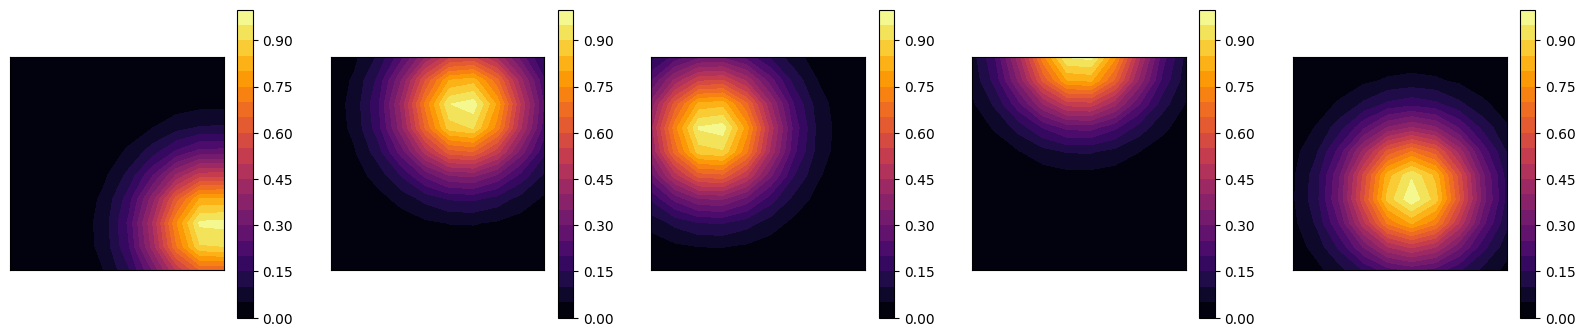

In [17]:
# Viz random PCs
source_states_all = PCs.get_state(evaluate_at=None, pos=env_coords_small).T 

np.random.seed(42)
neuron_indices = np.random.choice(source_states_all.shape[1], size=5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, neuron_idx in zip(axes, neuron_indices):
    source_states_curr = source_states_all[:, neuron_idx].reshape(len(ypos), len(xpos))
    # cbar_vals = ax.imshow(source_states_curr, cmap=cmap_ratemap)
    cbar_vals = ax.contourf(xpos, ypos, source_states_curr, cmap=cmap_ratemap, levels=20)
    ax.set_aspect('equal')
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())
    fig.colorbar(cbar_vals, ax=ax)

plt.show()

### Decode position from PC activity

/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


positions_std [[0.01604929 0.02020136]
 [0.01080915 0.02145346]
 [0.01339067 0.01020037]
 ...
 [0.02438358 0.00643564]
 [0.03754983 0.01201751]
 [0.02988154 0.01311848]]


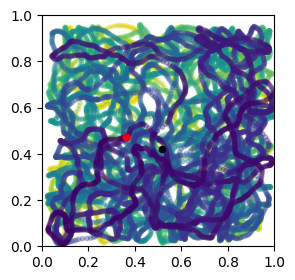

In [18]:
decoder_PC2d.train_xy_Net(PCs, Ag,epochs=100)
positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='dropoutNet')
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,dataset.observation, method='dropoutNet',return_std=True)
print('positions_std',positions_std)

# dataset_positions = decoder_PC2d.simple_decode_position(dataset.observation,env_coords,pc_full_env,plot=True)
# # WORKS only when dx=0.01 in Ag.Environment.discretise_environment(dx=0.01) ?
# print(dataset_positions.shape)
# decoder_PC2d.train_decoder(PCs,env_coords=env_coords, method='GP') # GP  # method='LR'
# positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='GP') 
# positions_pred, positions_std = decoder_PC2d.decode_position(PCs,dataset.observation, method='GP',return_std=True)
# print('positions_std',positions_std)

### Model stuff - restoring checkpoint

In [19]:
state, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env)

print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))
# num_state_dims is the expected number of input place cells
print(state.generator.apply_fn)  # MLP (num_layers = 3, num_hidden_units = 32, num_atoms = 11, num_state_dims = 50)
# print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, 

[17:59:55] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=9383;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=781966;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

           INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=333833;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=199580;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=533524;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=569981;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir
debug latest_step 500000


[18:00:17] INFO     Restoring item from                                                         ]8;id=946745;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=597695;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


[18:00:18] INFO     Finished restoring checkpoint from                                          ]8;id=596315;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=604227;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

Saved model state: Generator params shapes: {'params': {'model': {'Dense_0': {'bias': (10, 32), 'kernel': (10, 55, 32)}, 'Dense_1': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_2': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_3': {'bias': (10, 50), 'kernel': (10, 32, 50)}}}}
<bound method Module.apply of DistributionalSRGenerator(
    # attributes
    model = MLP(
        # attributes
        num_layers = 3
        num_hidden_units = 32
        num_outputs = None
        module = Dense
        activation = leaky_relu
        dtype = float32
        param_dtype = float32
    )
    num_atoms = 10
    num_state_dims = 50
)>


### compute DSM samples

atom_input = latent+source_state

DSM model input (n_samples, n_atoms, atom_input)

source pos:  [0.35 0.95]
Max SD of samples decoded with dropoutNet: (0.14832145, 0.15661001) ; Atom 1
Max SD of samples decoded with dropoutNet: (0.15269512, 0.21299022) ; Atom 4
Max SD of samples decoded with dropoutNet: (0.22764106, 0.15926836) ; Atom 9
decoded source:  [0.34897828 0.9243102 ]


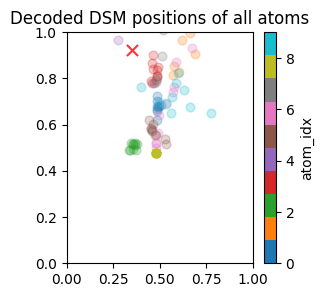

In [20]:
source_idx = 3
source=source_states_env[source_idx]
print('source pos: ',env_coords_small[source_idx])
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source, num_samples = num_samples )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='GP')

# atom_idx = 2
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')
# # plot of positions_pred
# modelviz_utils.plot_samples(PCs, dataset.observation, samples,source, make_dataset=False,atom=atom_idx,method='dropoutNet')

original source:  [0.55 0.25]
Max SD of samples decoded with dropoutNet: (0.2809182, 0.26933444) ; Atom 9
decoded source:  [0.54045963 0.25622284]


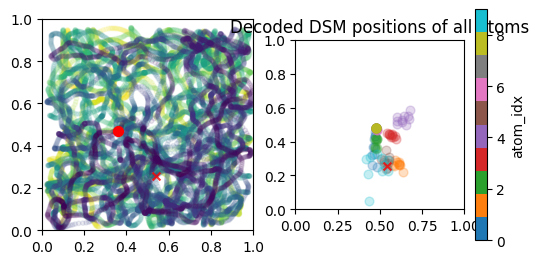

original source:  [0.55 0.25]
Max SD of samples decoded with dropoutNet: (0.24812648, 0.29266474) ; Atom 9
decoded source:  [0.54045963 0.25622284]


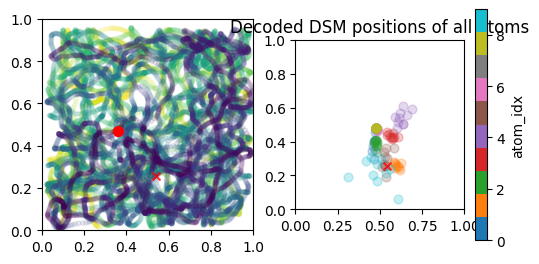

In [21]:
source_idx = 75
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(0)
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=True,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

source_idx = 75
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(2)
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=True,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

original source:  [0.55 0.25]
Using provided zs
Max SD of samples decoded with dropoutNet: (0.10844977, 0.10722472) ; Atom 4
Max SD of samples decoded with dropoutNet: (0.4565022, 0.4016738) ; Atom 9
decoded source:  [0.54045963 0.25622284]


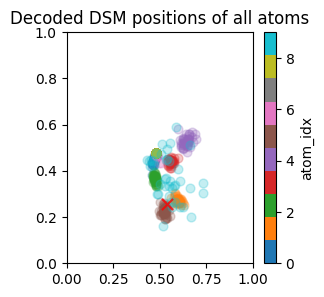

In [22]:
num_samples= 40
source_idx = 75
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(10)
z0 = np.ones((num_samples, config.num_outer, config.latent_dims)) #*10  # latent_rng not used if zs provided
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, latent_rng,zs=z0, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

##### Decoder uncertainty

In [23]:
# # showing SDs of decoded samples - 1 from each atom 
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[:,3,:], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')

# # showing SDs of decoded samples - from 4th atom
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[3,:,:], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')

In [24]:
# import matplotlib.pyplot as plt
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize
# cmap = plt.get_cmap('tab10')

# atom_idx_values = np.arange(10) #[3,4,8]
# norm = Normalize(vmin=min(atom_idx_values), vmax=max(atom_idx_values))

# for atom_idx in atom_idx_values:
#     method='dropoutNet'
#     positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method=method,return_std=True)
#     plt.scatter(positions_std[:, 0], positions_std[:, 1], color=cmap(norm(atom_idx)), s=40)
#     # range_column1 = (np.min(positions_std[:, 0]), np.max(positions_std[:, 0]))
#     # range_column2 = (np.min(positions_std[:, 1]), np.max(positions_std[:, 1]))
#     maxc1, maxc2 = np.max(positions_std[:, 0]), np.max(positions_std[:, 1])
#     if maxc1 > 0.1 and maxc2 > 0.1:
#         print(f'Max SD of decoded samples of atom {atom_idx} with {method}: {maxc1, maxc2}')

# # Create a ScalarMappable object and use it to add a colorbar to the plot
# sm = ScalarMappable(cmap=cmap, norm=norm)
# plt.colorbar(sm, ax=plt.gca(), label='atom_idx')
# plt.show()

### Exploring biases - average the rate maps

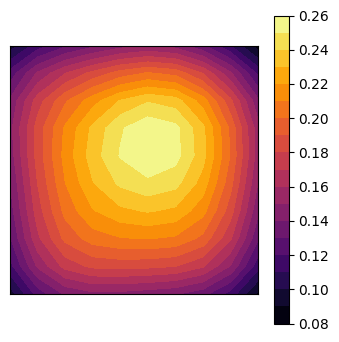

In [25]:
source_states_curr = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
source_states_curr.shape
total_PC_avg = np.mean(source_states_curr, axis=1)
total_PC_avg = total_PC_avg.reshape(len(ypos), len(xpos))
fig, ax = plt.subplots(figsize=(4, 4))
# cbar_vals = ax.imshow(total_PC_avg, cmap=cmap_ratemap, aspect='auto') 
cbar_vals = ax.contourf(xpos, ypos, total_PC_avg, cmap=cmap_ratemap, levels=20)
ax.set_aspect('equal')
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
fig.colorbar(cbar_vals)
plt.show()

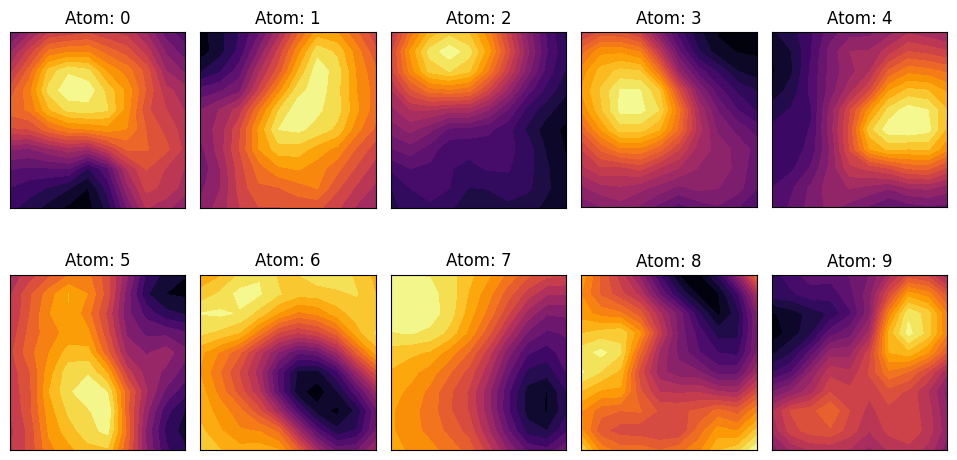

In [26]:
# - average all the rate maps of all neurons of 1 and see if it points to any direction??? 
# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_curr,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer) 

modelviz_utils.plot_neuron_activations(activations_layer_all_atoms, neuron_idx='avg', #figlabel=f'Average all neurons - each atom - latent {latent_rng_seed}'
                                       xpos=xpos,ypos=ypos)


In [27]:
# For instance, random walks produced more random rate maps, while the thigmotaxis dataset led to asymmetrical maps concentrated near boundaries.

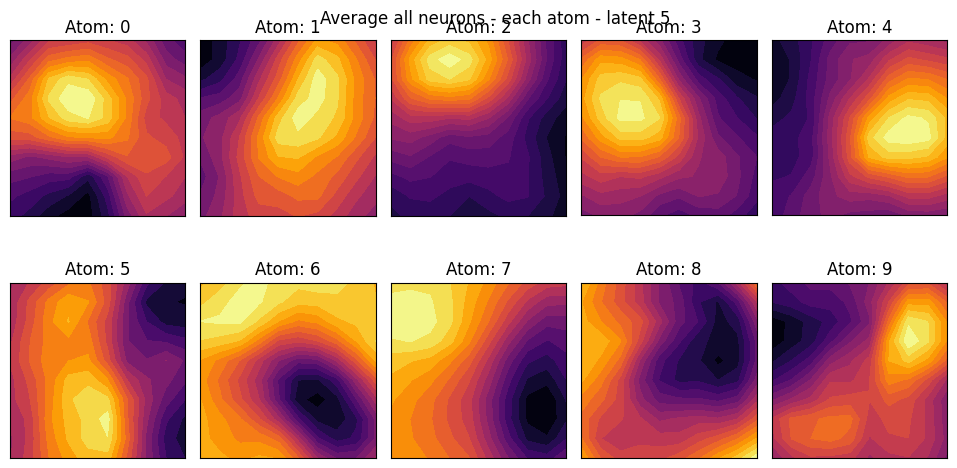

In [28]:
latent_rng_seed = 5
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_curr,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer) 

modelviz_utils.plot_neuron_activations(activations_layer_all_atoms, neuron_idx='avg',figlabel=f'Average all neurons - each atom - latent {latent_rng_seed}',
                                       xpos=xpos,ypos=ypos)

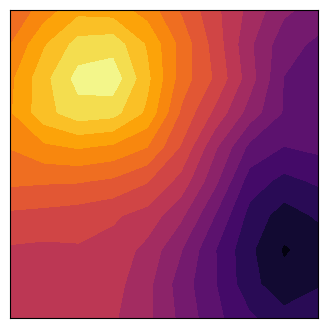

In [29]:
# figlabel='Average all atoms first - then PCs'
atoms_avg = np.mean(np.array(activations_layer_all_atoms), axis=0)
total_PC_avg = np.mean(atoms_avg, axis=1)
activations_2d = total_PC_avg.reshape(len(ypos), len(xpos))

fig, ax = plt.subplots(figsize=(4, 4))
ax.contourf(xpos, ypos, activations_2d, cmap=cmap_ratemap, levels=20)
ax.set_aspect('equal')
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
# fig.suptitle(f'{figlabel}')
plt.show()

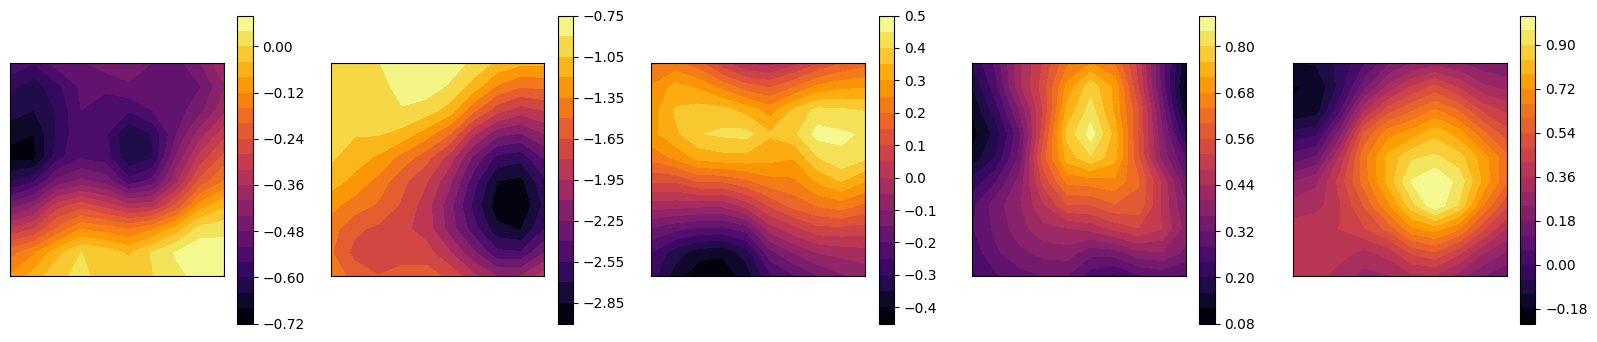

In [30]:
# plot random avg_atom_predictions - predictive SRs of Place cells

normalize = False
cmap_ratemap = 'inferno'  
atoms_avg = np.mean(np.array(activations_layer_all_atoms), axis=0)

np.random.seed(42)
neuron_indices = np.random.choice(source_states_all.shape[1], size=5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
# if normalize:
#     vmin, vmax = activations_layer.min(), activations_layer.max()

for ax, neuron_idx in zip(axes, neuron_indices):
    source_states_curr = atoms_avg.T[neuron_idx].reshape(len(ypos), len(xpos))
    # cbar_vals = ax.imshow(source_states_curr, cmap=cmap_ratemap)
    cbar_vals = ax.contourf(xpos, ypos, source_states_curr, cmap=cmap_ratemap, levels=20)
    # contour_set = ax.contourf(xpos, ypos, source_states_curr, cmap=cmap_ratemap, levels=20, vmin=vmin, vmax=vmax,)
    ax.set_aspect('equal')
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())
    fig.colorbar(cbar_vals, ax=ax)

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("bottom", size="5%", pad=0.1)  # Adjusted the colorbar size to 5%
    # cbar = fig.colorbar(contour_set, cax=cax, orientation="horizontal", ticks = [activations_2d.min(), activations_2d.max()]) #cbar = 
    # cbar.ax.xaxis.set_ticks_position('top')
    # cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    # ax.set_box_aspect(1)  
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')

plt.show()

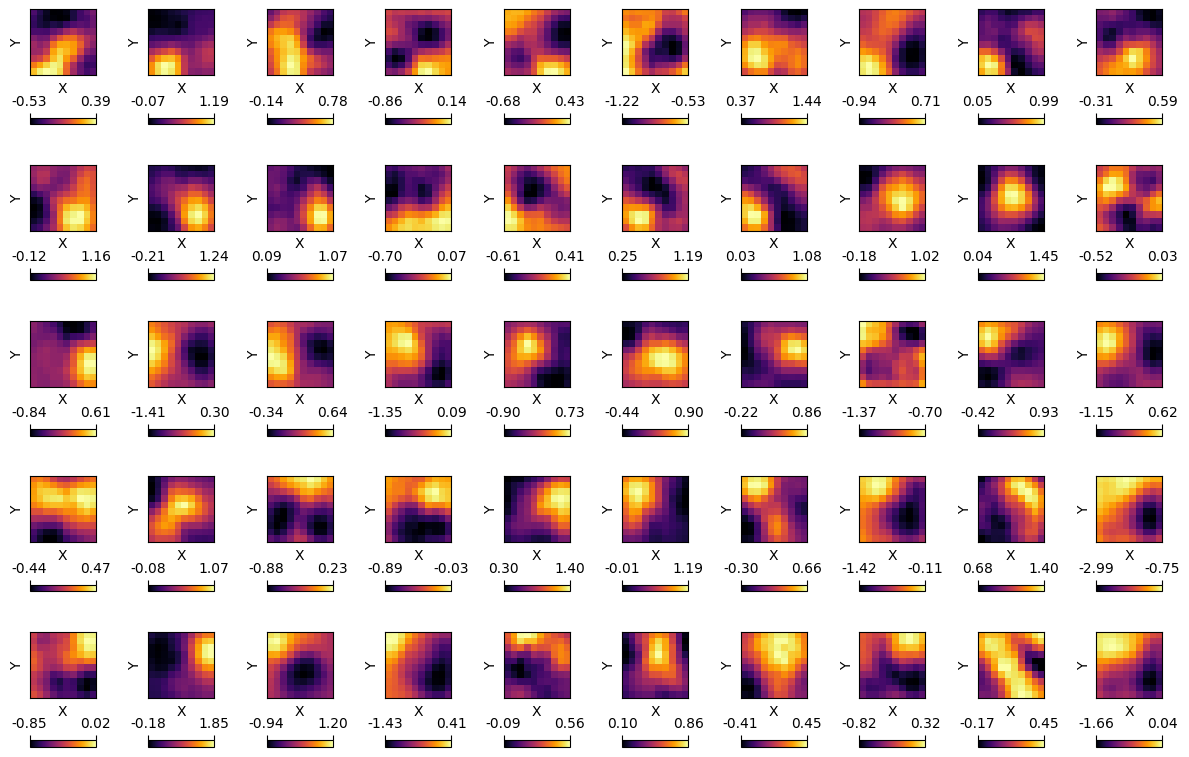

In [31]:
figlabel = 'Average all atoms first - viz each PC'
normalize = False
cmap_ratemap = 'inferno'  
atoms_avg = np.mean(np.array(activations_layer_all_atoms), axis=0)

Cols = 10
Rows = 5
gs = gridspec.GridSpec(Rows, Cols, width_ratios=[1]*Cols)
fig = plt.figure(figsize=(12, 8))

# Set normalization range if needed
if normalize:
    vmin, vmax = activations_layer.min(), activations_layer.max()

for k, neuron_i in enumerate(atoms_avg.T):
    ax = fig.add_subplot(gs[k // Cols, k % Cols])
    activations_2d = neuron_i.reshape(len(ypos), len(xpos))
    
    # Plot activations with normalization if required
    if normalize:
        contour_set = ax.imshow(activations_2d, cmap=cmap_ratemap, vmin=vmin, vmax=vmax, aspect='auto')
    else:
        contour_set = ax.imshow(activations_2d, cmap=cmap_ratemap, aspect='auto')
        # contour_set = ax.contourf(xpos, ypos, activations_2d, cmap=cmap_ratemap, levels=20)
    
    # Create a colorbar with adjusted size and spacing
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)  # Adjusted the colorbar size to 5%
    cbar = fig.colorbar(contour_set, cax=cax, orientation="horizontal", ticks = [activations_2d.min(), activations_2d.max()]) #cbar = 
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    # cbar.locator = ticker.MaxNLocator(nbins=3)
    # cbar.update_ticks()

    # Adjust the aspect ratio and remove tick labels
    ax.set_box_aspect(1)  
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

# If normalization is applied, create an extra colorbar for the entire figure
if normalize:
    cbar_ax = fig.add_subplot(gs[:, -1])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap_ratemap, norm=norm)

plt.tight_layout()
plt.show()


### ALL SOURCES _ PREDICTIONs

/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')
Processing atoms: 100%|██████████| 10/10 [05:12<00:00, 31.26s/it]
/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py:416: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


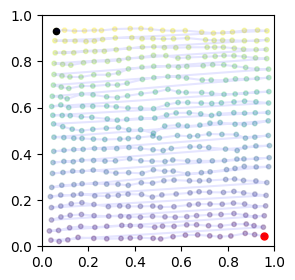

<Figure size 640x480 with 0 Axes>

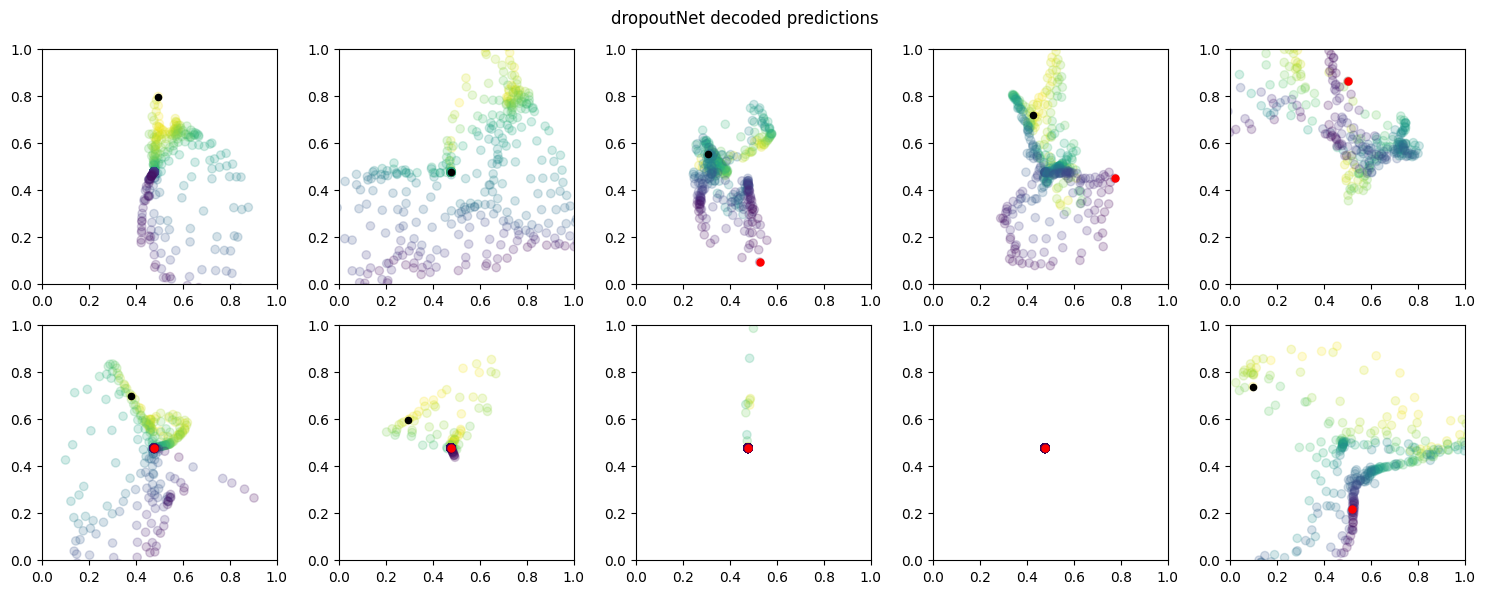

In [32]:
env_coords_point05 = Ag.Environment.discretise_environment(dx=0.05) # dx=Ag.environment.scale/10 , dx=0.01
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_point05 = env_coords_point05.reshape(-1, env_coords_point05.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_PCs = PCs.get_state(evaluate_at=None, pos=env_coords_point05).T

# source_PCs = source_states_env #[::2]
latent_rng_seed = 0
positions_source  = decoder_PC2d.decode_position(PCs, source_PCs , plot=True, method='dropoutNet')
modelviz_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, source_PCs, 
                              PCs, method='dropoutNet', title='dropoutNet decoded predictions')

# atom_idx = [8]
# modelviz_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, source_states, 
#                               PCs, atoms_sel=atom_idx, method='dropoutNet')

NEURON:  6


/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py:249: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.2, hspace=0.2)


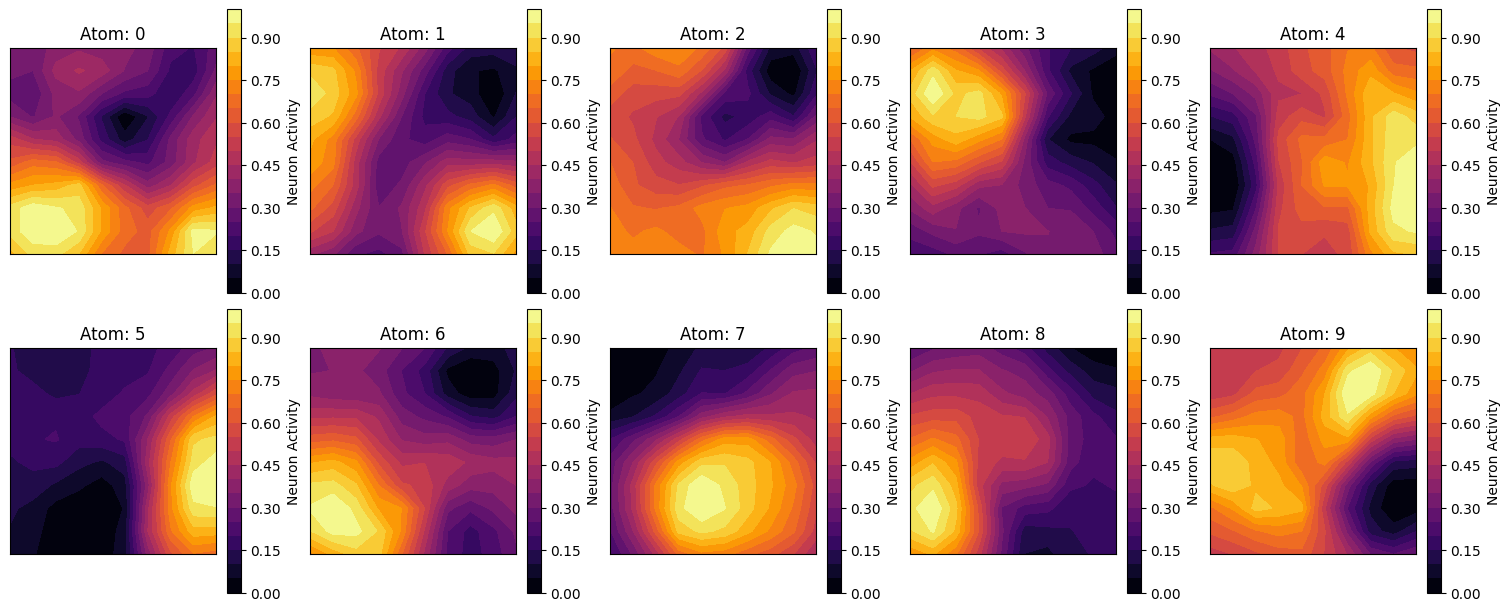

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


(<Figure size 250x250 with 2 Axes>, array([<Axes: >], dtype=object))

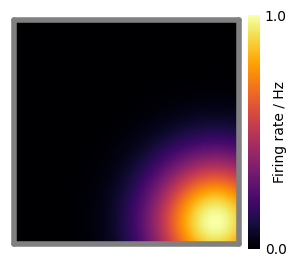

In [33]:
neuron_idx=6
print('NEURON: ', neuron_idx)
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])

In [34]:
activations_layer_all_atoms_arr = np.array(activations_layer_all_atoms)

In [35]:
modelviz_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, source_PCs, 
                              PCs, method='dropoutNet', title='dropoutNet decoded predictions')

Processing atoms:  30%|███       | 3/10 [00:40<01:35, 13.60s/it]

In [ ]:
# PCs.place_cell_centres[0]
#  = [0.4 , 0.13]

### Plot intermediate activations of ith Atom


- Plot intermediate activations as 2D maps of neurons - theta (0-360) vs velocity - but model is trained with cos(theta),sin(theta),velocity \
2.1. Freeze latent and see with different source states and same latent? \
2.2 Change latents slightly - tiny changes? \
2.3 see which neurons dont change when latents change a lot
- Activations over layers - entropy of neuron - average over each dim

In [63]:
# Selecting the model atom to use, and extracting its parameters , also get corresponding input
#TODO
atom_i = 0  # ith atom
num_outer = config.num_outer 
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, num_outer)
print("Extracted params shapes for the i-th model:")
# print_params_shapes(atom_params)
print(jax.tree_map(jnp.shape, atom_params))

Extracted params shapes for the i-th model:
{'Dense_0': {'bias': (32,), 'kernel': (55, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_3': {'bias': (50,), 'kernel': (32, 50)}}


### Dense 3 activations  - PC ratemaps 

Dense 3 activations correspond to 50 PCs outputs per source; should look like place cell ratemaps 

#### different Zs - latents

In [ ]:
# - here,  test different latents
layers = ['Dense_3',]

activations_layer_randomz = []
for i in range(3):
    zs = jax.random.normal(jax.random.PRNGKey(i), (config.latent_dims,))
    # zs = np.ones((config.latent_dims)) *np.exp(i) # latent_rng not used if zs provided
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

# Plotting all the neurons
# for i in range(len(activations_layer_randomz)):
#     neuron_idx = np.arange(activations_layer_randomz[i].shape[-1])
#     modelviz_utils.plot_neuron_activations(activations_layer_randomz[i],neuron_idx,layers,xpos,ypos)
#     # neuron_idx=0
#     # modelviz_utils.plot_neuron_activations(activations_layer_randomz[i],neuron_idx,layers,xpos,ypos)

neuron_idx=40
print('NEURON: ', neuron_idx)
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_randomz, 'latent rng key', neuron_idx, xpos, ypos)
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
## to see scale
# modelviz_utils.plot_neuron_activations(activations_layer_randomz[0],neuron_idx,layers,xpos,ypos)


### Experimenting with changed basis vectors

- Generalization - changing place cell centres of 1 PC at a time - DSM
-  Changing all PC, locations once if 1 changes, ... like bootstrapping
-  Comparison of predicted rate maps with initial prediction when place cell centres are the same as trained model


In [ ]:
# PC_num=1
# atoms_avg = atoms_avg_activation[:,PC_num].reshape(len(ypos), len(xpos))
# fig, ax = plt.subplots(figsize=(4, 4))
# # cbar_vals = ax.imshow(total_PC_avg, cmap=cmap_ratemap, aspect='auto') 
# cbar_vals = ax.contourf(xpos, ypos, atoms_avg, cmap=cmap_ratemap, levels=20)
# ax.set_aspect('equal')
# ax.xaxis.set_major_locator(ticker.NullLocator())
# ax.yaxis.set_major_locator(ticker.NullLocator())
# fig.colorbar(cbar_vals)
# plt.show()

In [92]:
importlib.reload(modelviz_utils)

<module 'model_viz_functions_riab' from '/home/sruthi/Documents/thesis/distributional-sr/model_viz_functions_riab.py'>

In [8]:
gaussian_input_PC_allsources = PCs.get_state(evaluate_at= None, pos = env_coords_small ).T # evaluate_at= "all"  # shape(n_sources, n_PCs=50)
neuron_list = np.arange(gaussian_input_PC_allsources.shape[1])

# Precompute the atom parameters once and store them
atom_params_list = [
    modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer)
    for atom_num in range(config.num_outer)
]

layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

# Precompute the activations for the initial centers
activations_layer_all_atoms = [
    modelviz_utils.compute_activation_layer_all_sources(
        state.generator, 
        atom_params_list[atom_num],
        gaussian_input_PC_allsources, zs, layers
    ) for atom_num in range(config.num_outer)
]
atoms_avg_activation_initial = np.mean(activations_layer_all_atoms, axis=0)

In [10]:
# optimized
bootstrap_nums = 5 
PCs.place_cell_centres = orig_pc_centres.copy()

num_skip=1
# Preallocate memory for neuron_scores_changedPCs
neuron_scores_changedPCs = np.empty((len(neuron_list) // num_skip, bootstrap_nums * len(neuron_list)))

np.random.seed(42)
for i, num_PCs_to_change in enumerate(neuron_list[::num_skip]):
    print(f'Changing {num_PCs_to_change+1} place cell centres')   

    bootstrap_scores = []
    for bootstrap_num in range(bootstrap_nums):
        new_centres = np.random.uniform(size=(num_PCs_to_change+1, 2))
        pc_indices_to_change = np.random.choice(neuron_list, size=num_PCs_to_change+1, replace=False)
        # print('debug pc_indices_to_change:',pc_indices_to_change)
        PCs.place_cell_centres[pc_indices_to_change] = new_centres
        changed_source_states = PCs.get_state(evaluate_at=None, pos=env_coords_small).T

        activations_layer_all_atoms = [
            modelviz_utils.compute_activation_layer_all_sources(
                state.generator, 
                atom_params_list[atom_num],
                changed_source_states, zs, layers
            ) for atom_num in range(config.num_outer)
        ]

        atoms_avg = np.mean(activations_layer_all_atoms, axis=0)
        assert atoms_avg.shape == atoms_avg_activation_initial.shape # remove

        neuron_scores = modelviz_utils.compute_distsim_trueratemap_vs_predratemap_allneurons(
            true_ratemap_all=atoms_avg_activation_initial, 
            ratemap_model=atoms_avg, 
            neuron_list=neuron_list, 
            metric='cosine'
        )
        bootstrap_scores.append(neuron_scores)
        PCs.place_cell_centres = orig_pc_centres.copy()

    neuron_scores_changedPCs[i] = np.hstack(bootstrap_scores)  # Flattened directly into the preallocated array

# Save results
with open('neuron_scores_changedPCs_DSM_all.pkl', 'wb') as f:
    pickle.dump(neuron_scores_changedPCs, f)
# with open('neuron_scores_changedPCs_DSM_5.pkl', 'wb') as f:
#     pickle.dump(neuron_scores_changedPCs, f)


Changing 1 place cell centres
Changing 2 place cell centres
Changing 3 place cell centres
Changing 4 place cell centres
Changing 5 place cell centres
Changing 6 place cell centres
Changing 7 place cell centres
Changing 8 place cell centres
Changing 9 place cell centres
Changing 10 place cell centres
Changing 11 place cell centres
Changing 12 place cell centres
Changing 13 place cell centres
Changing 14 place cell centres
Changing 15 place cell centres
Changing 16 place cell centres
Changing 17 place cell centres
Changing 18 place cell centres
Changing 19 place cell centres
Changing 20 place cell centres
Changing 21 place cell centres
Changing 22 place cell centres
Changing 23 place cell centres
Changing 24 place cell centres
Changing 25 place cell centres
Changing 26 place cell centres
Changing 27 place cell centres
Changing 28 place cell centres
Changing 29 place cell centres
Changing 30 place cell centres
Changing 31 place cell centres
Changing 32 place cell centres
Changing 33 place

/tmp/ipykernel_1592093/764751898.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the padding between and around the subplots


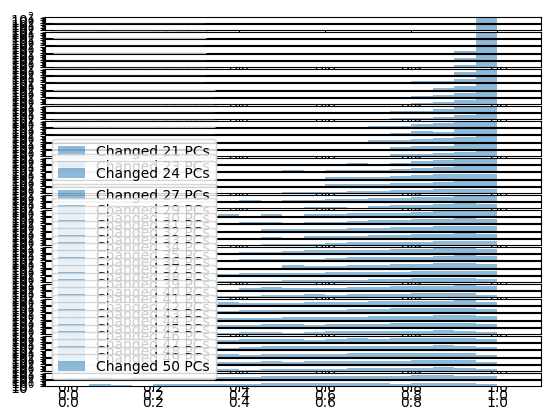

In [11]:
# Plots with changed PCs
selected_list = neuron_list[::num_skip]

bin_edges = np.arange(0, 1.1, 0.05)
ncols  = 1
fig, axs = plt.subplots(int(len(selected_list)/ncols),ncols)  # Adjust nrows and ncols to your needs
i=0
for ax, num_PCs_to_change in zip(axs.flatten(), selected_list):
    # for i, ax in enumerate(axs.flatten()):  # axs.flatten() returns a 1D array that can be iterated over
    ax.hist(neuron_scores_changedPCs[i], bins=bin_edges, alpha=0.5, label=f'Changed {num_PCs_to_change+1} PCs')
    ax.set_yscale('log') 
    ax.set_ylim([1, bootstrap_nums * len(neuron_list)])  # Set the limits of the y-axis
    ax.legend()  # Display the legend
    i=i+1
plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()

In [18]:
len(neuron_scores_changedPCs)

50

In [21]:
avg_scores = np.mean(neuron_scores_changedPCs, axis=1)
# plt.plot(avg_scores)
with open('neuron_scores_changedPCs_DSM_avgscores.pkl', 'wb') as f:
    pickle.dump(avg_scores, f)

: 

In [66]:
# Generalization - changing place cell centres of 1 PC at a time 
# Changing all PC, locations once if 1 changes, ... like bootstrapping

# optimized
np.random.seed(42)
PCs.place_cell_centres = orig_pc_centres.copy()

neurons_changedPCs = []
num_skip=10
for i, num_PCs_to_change in enumerate(neuron_list[::num_skip]):
    print(f'Changing {num_PCs_to_change+1} place cell centres')   
    new_centres = np.random.uniform(size=(num_PCs_to_change+1, 2))
    pc_indices_to_change = np.random.choice(neuron_list, size=num_PCs_to_change+1, replace=False)
    print('debug pc_indices_to_change:',pc_indices_to_change)
    PCs.place_cell_centres[pc_indices_to_change] = new_centres
    changed_source_states = PCs.get_state(evaluate_at=None, pos=env_coords_small).T

    activations_layer_all_atoms = [
        modelviz_utils.compute_activation_layer_all_sources(
            state.generator, 
            atom_params_list[atom_num],
            changed_source_states, zs, layers
        ) for atom_num in range(config.num_outer)
    ]
    atoms_avg = np.mean(activations_layer_all_atoms, axis=0)
    PCs.place_cell_centres = orig_pc_centres.copy()
    neurons_changedPCs.append(atoms_avg ) 

Changing 1 place cell centres
debug pc_indices_to_change: [19]


Changing 11 place cell centres
debug pc_indices_to_change: [49 29 21 13 47 45  5  3 37 22 27]
Changing 21 place cell centres
debug pc_indices_to_change: [28 13 17  9  6 12  7 48 42 15 46 25  8 29 21 26 19 33 44 24 37]
Changing 31 place cell centres
debug pc_indices_to_change: [26 49 12 15 37 11 45  4  6 40 10  8 19 35 42 33 48 25  1 14 44 13  7 38
 21  9 24 17  2  0 22]
Changing 41 place cell centres
debug pc_indices_to_change: [45 25  5 29 15 35 30 14 44 43 24 10 46 20  4 21  3  6  8 47 41 33  7 16
 22 38 17 18 49 13 37 12 28  9 39  0  2 42 36 40 32]


In [68]:
def plot_changedPCs(neurons_changedPCs, sel_neuron_idx):
    nrows=1
    vmin = min(np.min(arr[:, sel_neuron_idx]) for arr in neurons_changedPCs)
    vmax = max(np.max(arr[:, sel_neuron_idx]) for arr in neurons_changedPCs) 
    fig, axs = plt.subplots(nrows,int(len(selected_list)/nrows)+1, figsize= (10,8)) 
    axs[0].imshow(atoms_avg_activation_initial[:,sel_neuron_idx].reshape(len(ypos), len(xpos)), cmap='inferno', vmin=vmin, vmax=vmax)
    axs[0].set_title('Original DSM PC')
    axs[0].set_xticks([])
    axs[0].set_yticks([]) 
    i=1
    for i, (ax, num_PCs_to_change) in enumerate(zip(axs.flatten()[1:], selected_list), start=0):
        ax.imshow(neurons_changedPCs[i][:,sel_neuron_idx].reshape(len(ypos), len(xpos)), cmap='inferno', vmin=vmin, vmax=vmax)
        # ax.imshow(activations_2d, cmap='inferno', extent=(0, 1, 0, 1), origin='lower')
        # ax.contourf(xpos, ypos, neurons_changedPCs[i][:,sel_neuron_idx].reshape(len(ypos), len(xpos)), cmap='inferno', levels=20)
        ax.set_xticks([])
        ax.set_yticks([]) 
        ax.set_title(f'Changed {num_PCs_to_change+1} PCs')
    plt.tight_layout()
    plt.show()

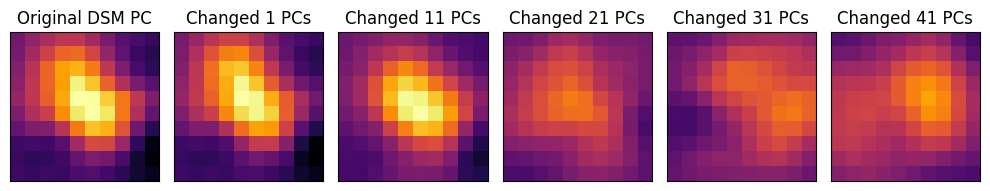

In [71]:
sel_neuron_idx = 25
plot_changedPCs(neurons_changedPCs, sel_neuron_idx)

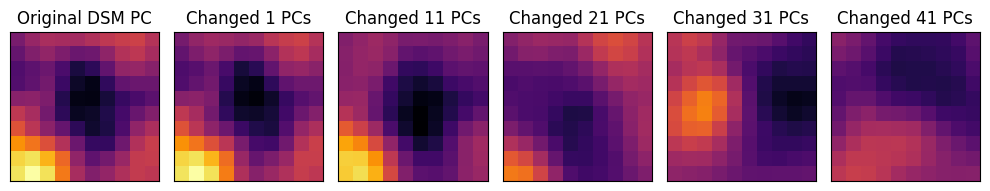

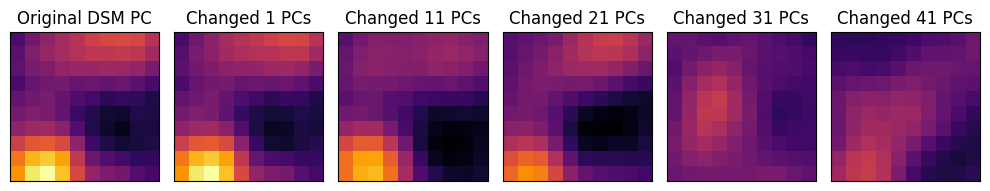

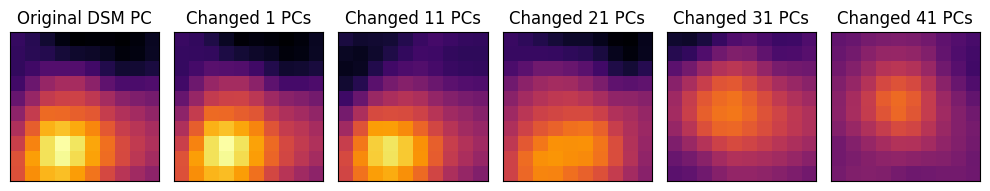

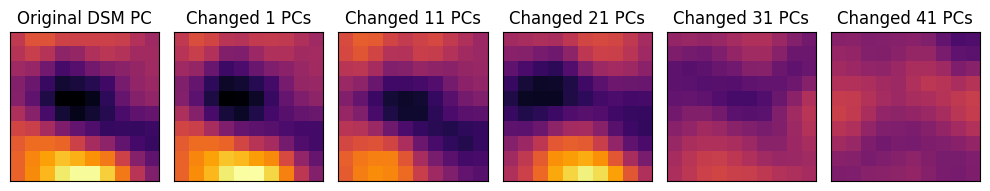

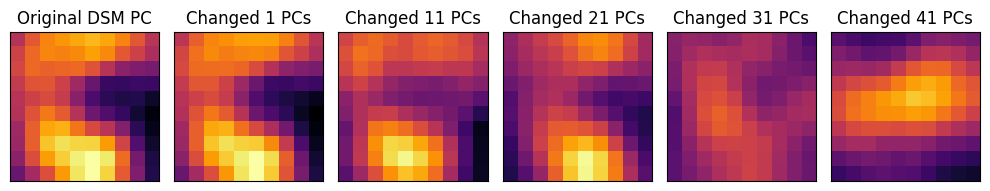

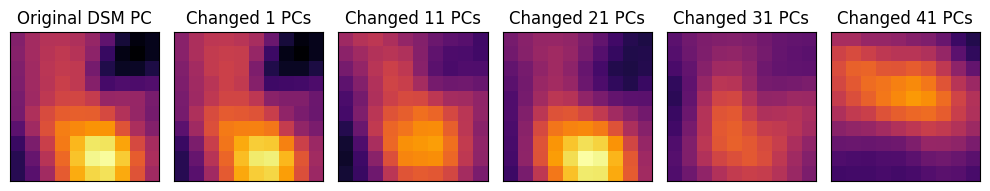

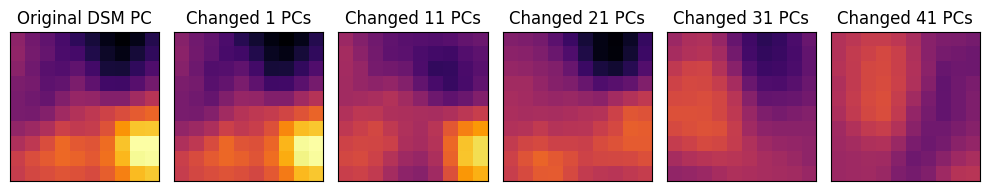

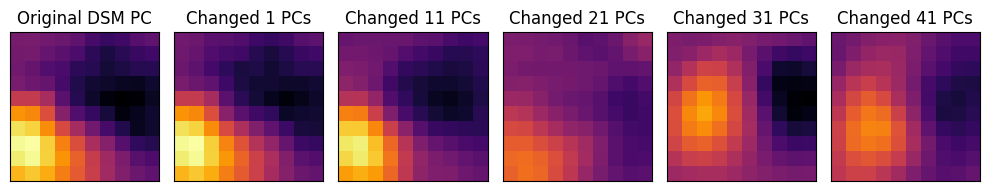

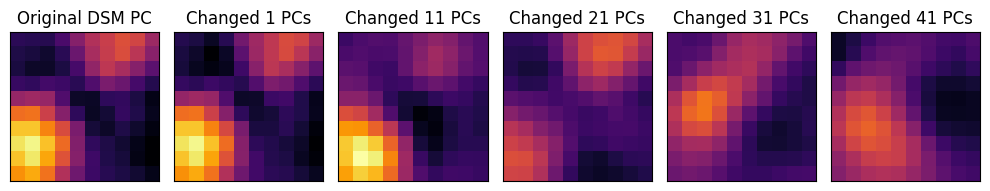

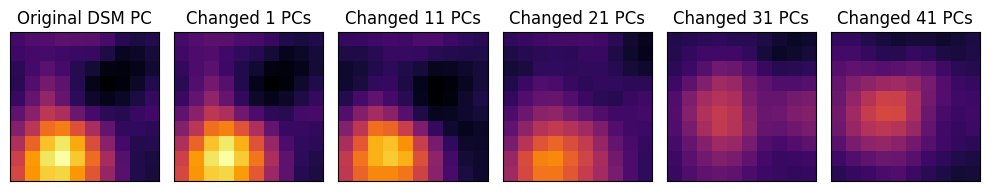

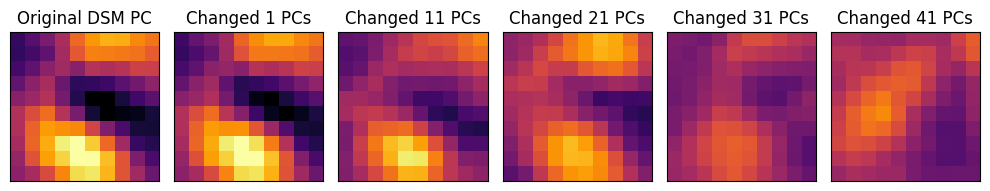

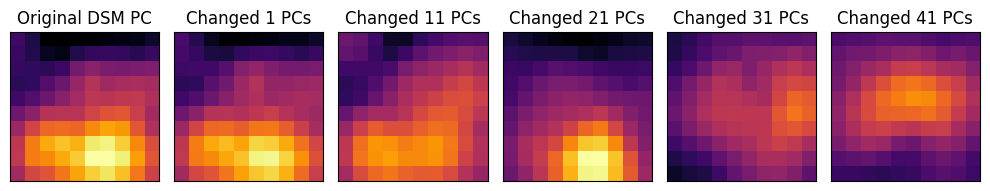

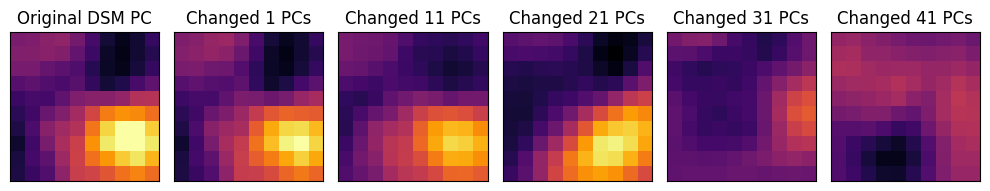

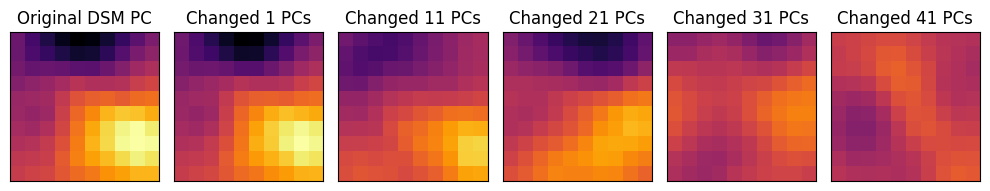

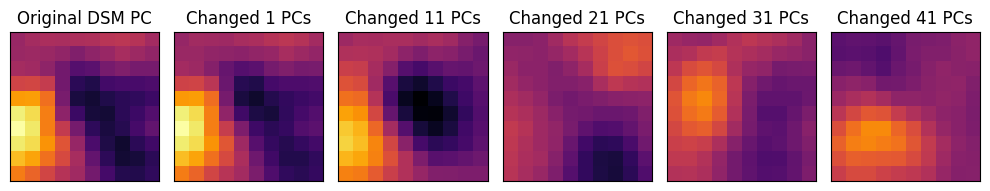

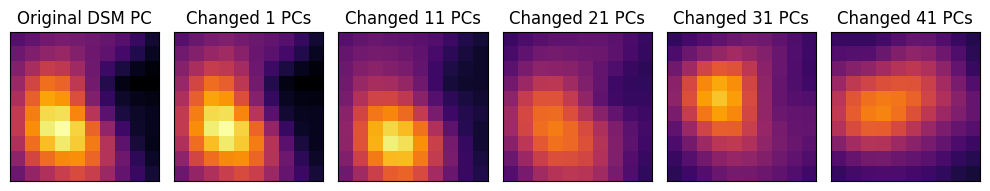

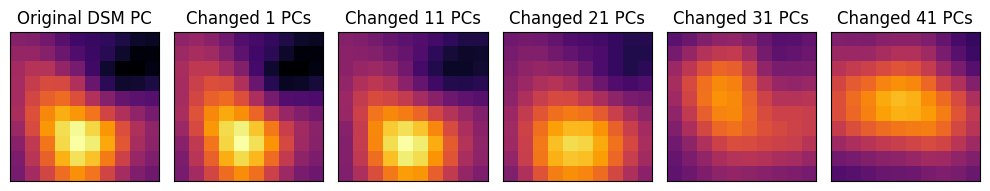

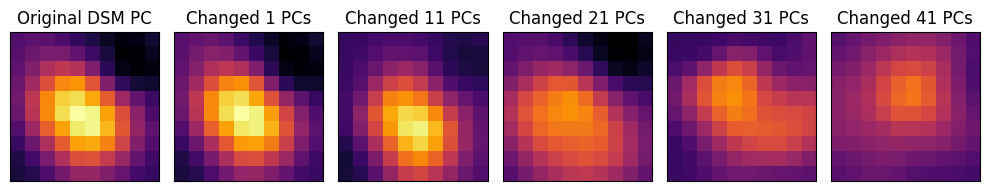

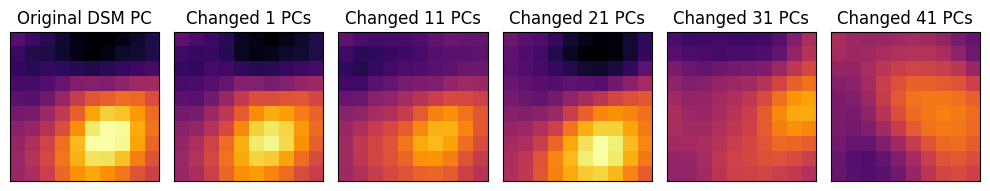

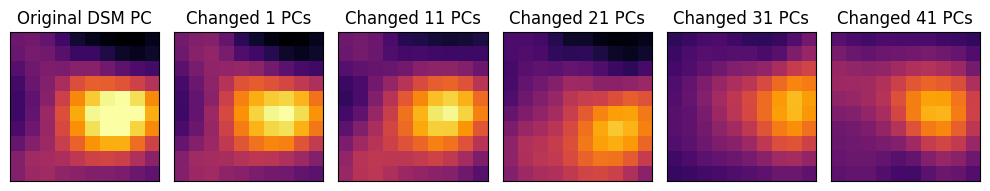

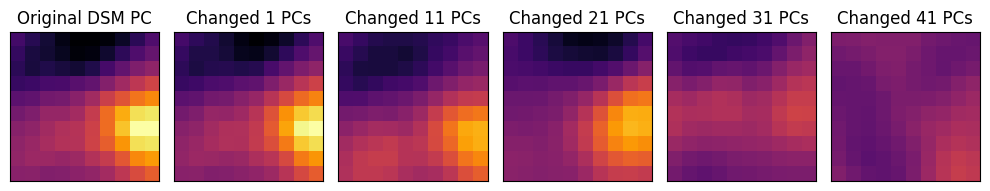

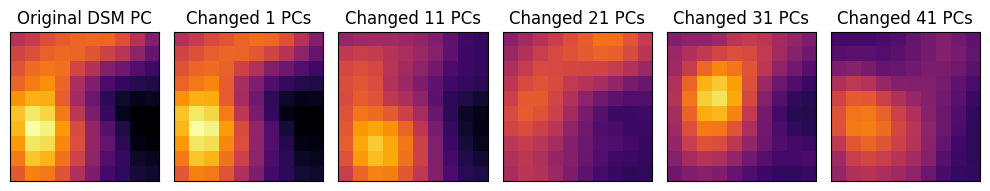

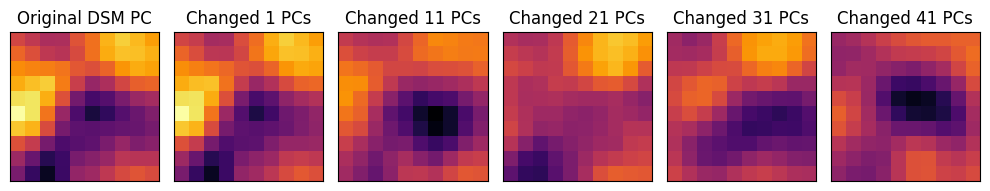

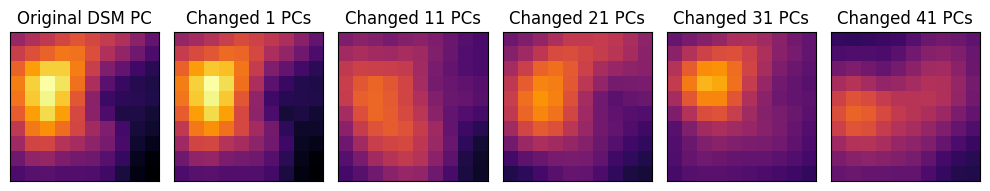

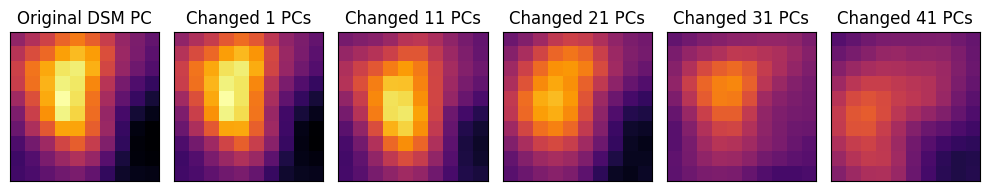

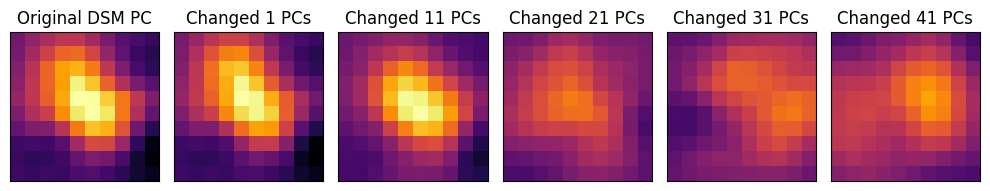

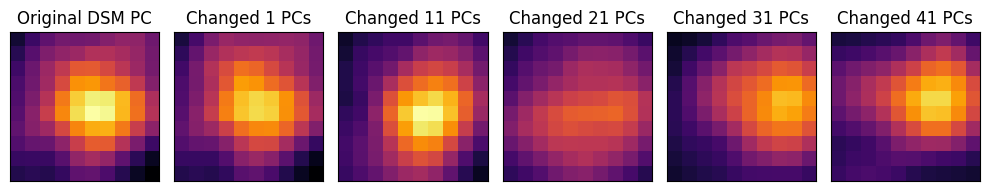

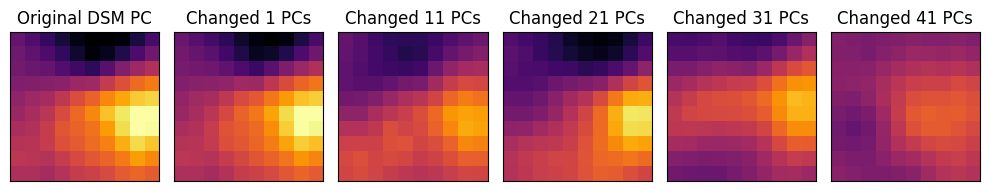

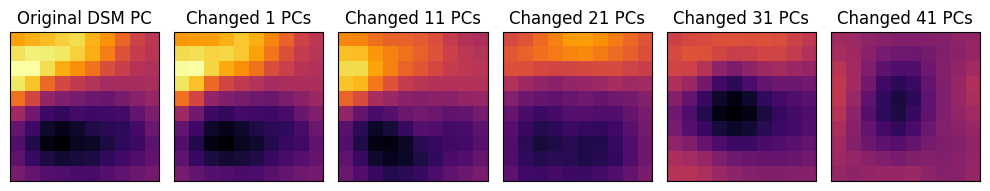

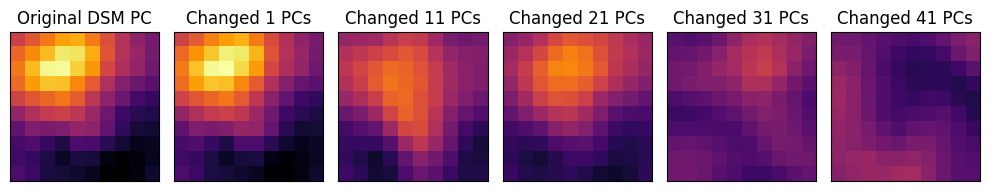

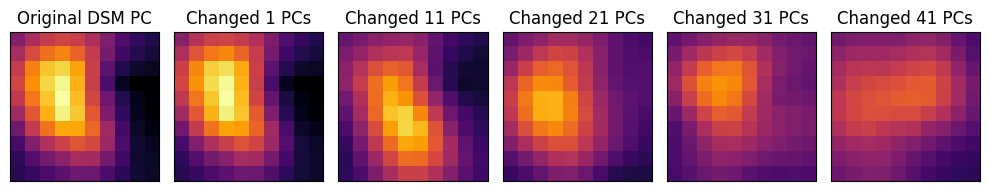

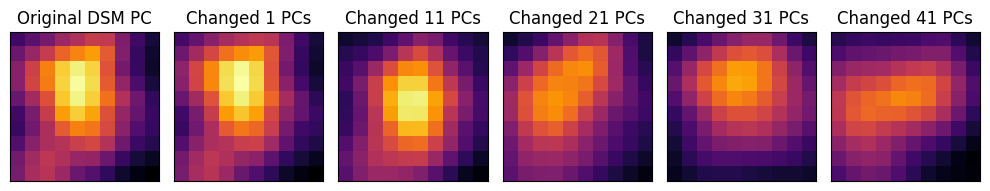

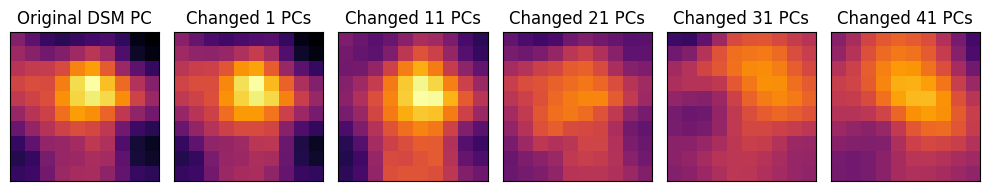

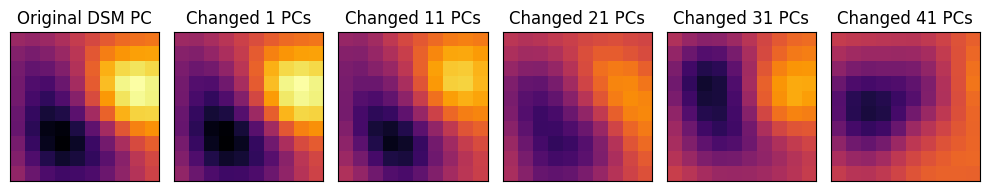

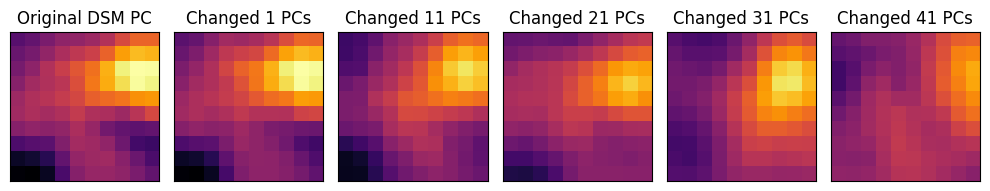

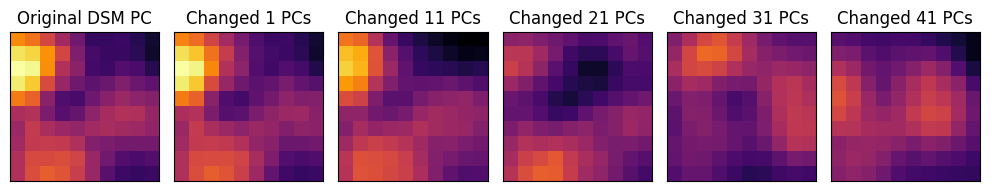

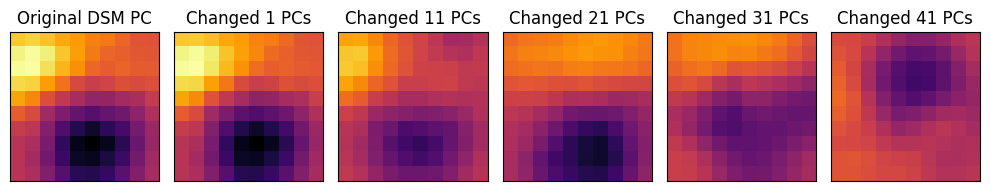

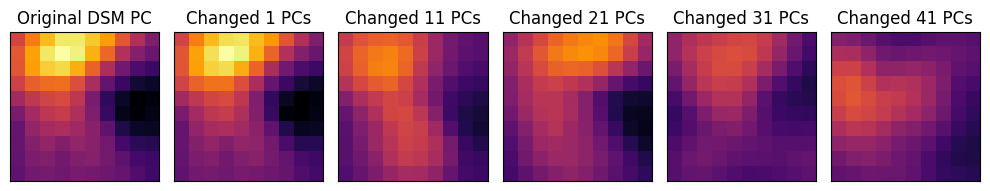

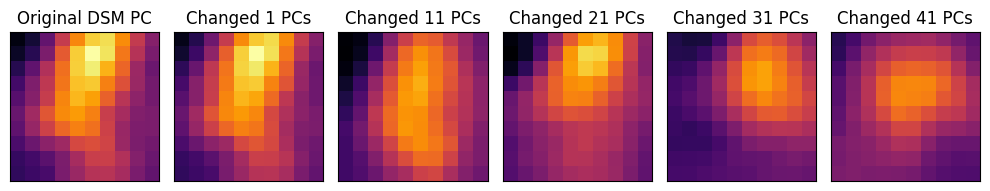

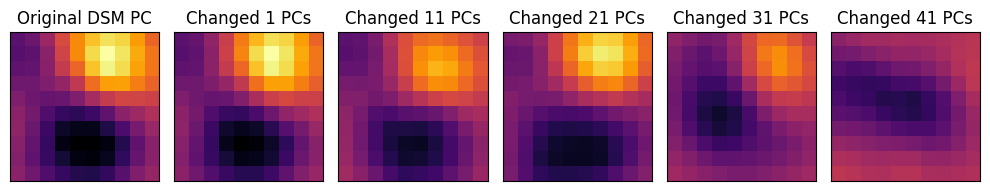

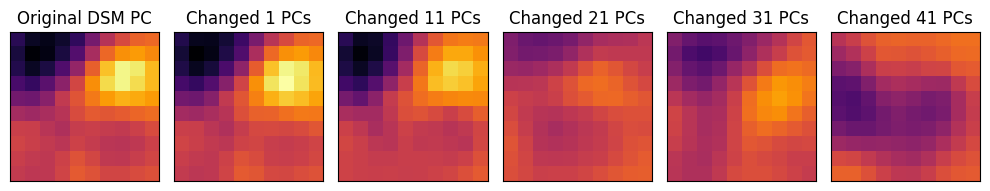

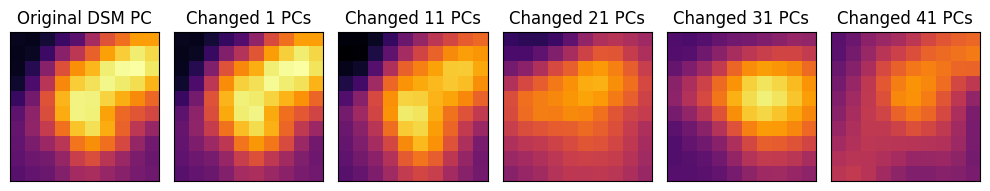

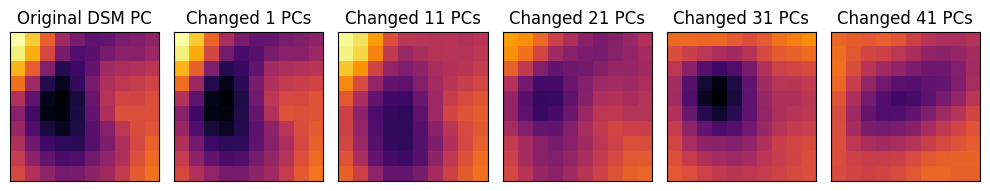

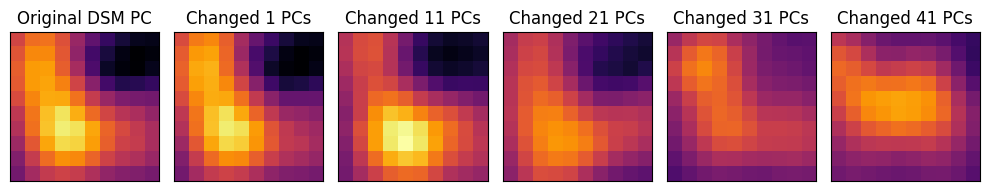

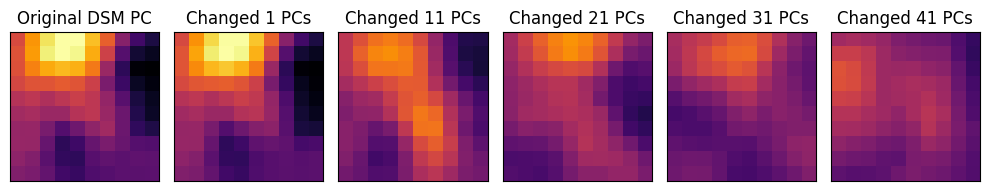

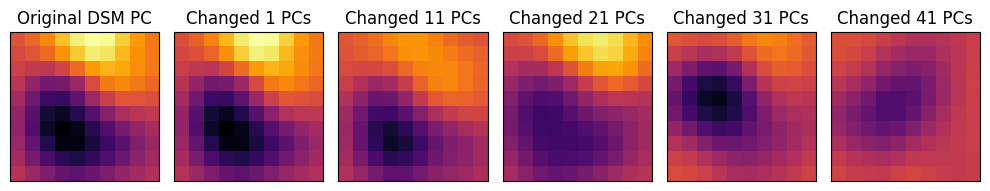

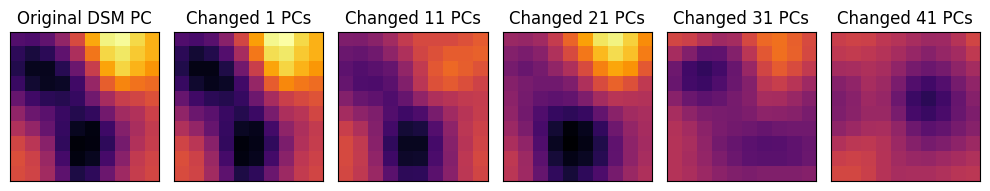

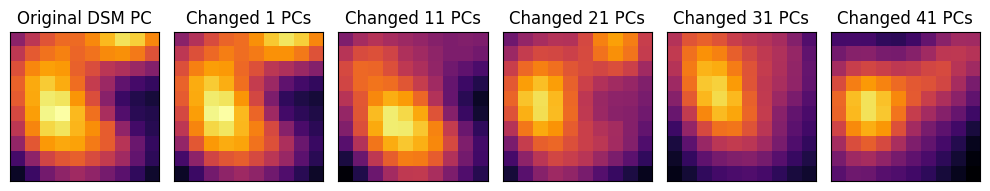

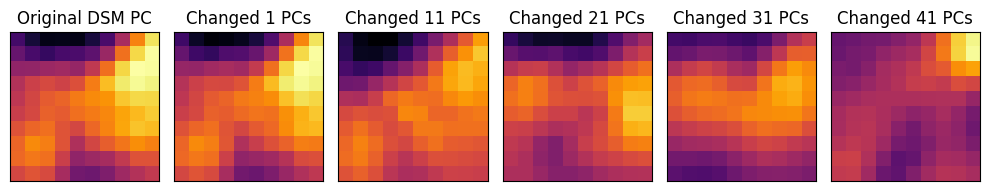

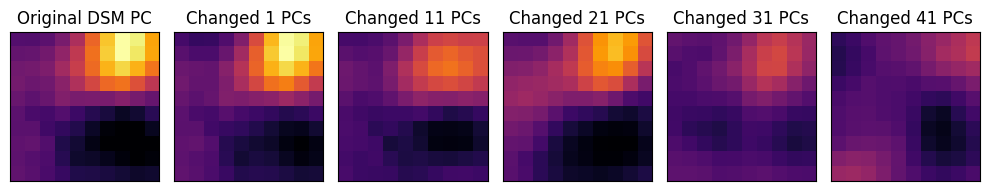

In [70]:
# Assuming you have 50 neurons
for neuron_idx in range(50):
    plot_changedPCs(neurons_changedPCs, neuron_idx)

### All ATOMS - Plot rate map of neuron_idx

In [ ]:
# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer)


In [ ]:
#TODO - select neuron_idx
neuron_idx=1 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
print(f'Layer: {layers} - Neuron: {neuron_idx}')
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)

# to see scale
# modelviz_utils.plot_neuron_activations(activations_layer_all_atoms[0],neuron_idx,layers,xpos,ypos)

In [ ]:
#TODO - select neuron_idx
neuron_idx=30 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
print(f'Layer: {layers} - Neuron: {neuron_idx}')
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)


In [ ]:
source_states_curr = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_curr,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer) 

#TODO - select neuron_idx
neuron_idx=40 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])

PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
print(f'Layer: {layers} - Neuron: {neuron_idx}')
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)

# neuron_idx
activations_neuron_all_atoms_allPCs = []
for atom_idx in range(len(activations_layer_all_atoms)):
    activations_neuron_all_atoms_allPCs.append(activations_layer_all_atoms[atom_idx][:, neuron_idx])

In [ ]:
# Changing basis vector - PC which is source  - canging source place  

PCs.place_cell_centres[0] = [0.4 , 0.53]
PCs.place_cell_centres[1] = [0.8 , 0.43]
changed_source_states = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print('CHANGE BASIS VECTOR: PCs.place_cell_centres')
PCs.place_cell_centres[0] = orig_pc_centres[0]
PCs.place_cell_centres[1] = orig_pc_centres[1]

# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, changed_source_states,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer)
activations_neuron_all_atoms_changedPCs = []
for atom_idx in range(len(activations_layer_all_atoms)):
    activations_neuron_all_atoms_changedPCs.append(activations_layer_all_atoms[atom_idx][:, neuron_idx])

layers = ['Dense_3',]
latent_rng_seed = 0 

for num_PCs in range(1, 5): # 50
    print(f'Changing {num_PCs} place cell centres ')
    for pc_idx in range(num_PCs):
        PCs.place_cell_centres[pc_idx] = np.random.rand(2)
    changed_source_states = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
    print(f'CHANGE BASIS VECTOR: PCs.place_cell_centres[{pc_idx}]')
    print(PCs.place_cell_centres[:10])
    for pc_idx in range(num_PCs):
        PCs.place_cell_centres[pc_idx] = orig_pc_centres[pc_idx]


    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

    activations_neuron_all_atoms_changedPCs = []
    for atom_num in range(config.num_outer):
        atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
        activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, changed_source_states,zs, layers)
        # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
        activations_neuron_all_atoms_changedPCs.append(activations_layer[atom_idx][:, neuron_idx])
        


distribution of changes across population
hypothesis -  more variability in changes for 
histograms of similarit measures - 

- dsm looks more like normal vs another might be dirac 
- for each neuron compare to ensemble of SRs - whether - ensemble is always to left

Compute euclidean distances / cosine similarity / correlation  - for changing 1 PC location upto changing 50 – for DSM vs SR in same plot – so 50 plots- (different distances when randomly reassigning PC location – so plot curves 

for al 10 atoms - 50 plots?

euclidean distance is between neurons - so average of all neurons?


---------------------------------------
Effect of changing 1 neurons's position till changing all neuron's positions 
- we're basically randomizing inputs
- measuring similarity between DSM rate maps when changing inputs - changes in all 50 neurons - so average ? or take worst similarity measure or average of 5 worst? - changes in 50 neurons - changes diferently in each atom
- Compare to gamma model


In [ ]:
layers = ['Dense_3',]
latent_rng_seed = 0 

for num_PCs in range(1, 5): # 50
    print(f'Changing {num_PCs} place cell centres ')
    for pc_idx in range(num_PCs):
        PCs.place_cell_centres[pc_idx] = np.random.rand(2)
    changed_source_states = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
    print(f'CHANGE BASIS VECTOR: PCs.place_cell_centres[{pc_idx}]')
    print(PCs.place_cell_centres[:10])
    for pc_idx in range(num_PCs):
        PCs.place_cell_centres[pc_idx] = orig_pc_centres[pc_idx]


    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

    activations_neuron_all_atoms_changedPCs = []
    for atom_num in range(config.num_outer):
        atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
        activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, changed_source_states,zs, layers)
        # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
        activations_neuron_all_atoms_changedPCs.append(activations_layer[atom_idx][:, neuron_idx])
        



In [ ]:
for atom_idx in range(len(activations_layer_all_atoms)):
    print(modelviz_utils.euclidean_distance(activations_neuron_all_atoms_allPCs[atom_idx], activations_neuron_all_atoms_changedPCs[atom_idx]))
    print('cosine: ',modelviz_utils.cosine_similarity(activations_neuron_all_atoms_allPCs[atom_idx], activations_neuron_all_atoms_changedPCs[atom_idx]))

In [ ]:
for atom_idx in range(len(activations_layer_all_atoms)):
    print(modelviz_utils.euclidean_distance(activations_neuron_all_atoms_allPCs[atom_idx], activations_neuron_all_atoms_changedPCs[atom_idx]))
    print('cosine: ',modelviz_utils.cosine_similarity(activations_neuron_all_atoms_allPCs[atom_idx], activations_neuron_all_atoms_changedPCs[atom_idx]))

In [ ]:
# Changing basis vector - PC which is source 
changed_source_states = source_states_env.copy()  # shape (100,50) when env discretized into 100 
changed_source_states[:,-10:]=0  # Zeroing out last 10 PCs
print('CHANGE BASIS VECTOR: source[:,-10:]=0')
# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, changed_source_states,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer) 

#TODO - select neuron_idx
neuron_idx=40 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
print(f'Layer: {layers} - Neuron: {neuron_idx}')
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)


DOES SKEW MATCH BEHAVIOR?
- from source : do these maps correspond to movement from 
- orig pc and skewewd field 

centre of mass of both - vector between them should corrrelate to direction
- circular correlation - polar dims - not needed
- angle between the vectors



### Different atom

In [ ]:
PCs.plot_rate_map()

In [ ]:
atom_idx = 9  # ith atom
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_idx, config.num_outer)
activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
print(f'activations_layer.shape: {activations_layer.shape}')
neuron_idx = np.arange(activations_layer.shape[-1])
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)
neuron_idx=40
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)

### to get the directional responses of internal neurons 

- choose 1 atom and 1 latent rng
- 1 source: dsm produces 1 sample 
- dropoutNN decodes the xy position
- .diff() for x and y
- head_direction = np.arctan2(dy, dx) 
- np.degrees(direction) ??
- rayleigh vector thing

Paper: Cells were classified as head direction cells if their  Rayleigh vector lengths in baseline trials exceeded the threshold of the 99th percentile population shuffling. 

high Rayleigh vector length indicates that the directions are concentrated around a certain value,

In [ ]:
# def resultant_vector(alpha_bins, nanrobust, axis=None, w=None, d=0)

In [ ]:
import pycircstat 
# if result['pval'] < 0.01:
#     print("The neuron can be classified as a head direction cell.")
# num_bins = 9
# neuron_ix = 0
# firing_rate = predicted_pcs_fromsources[:,neuron_ix]
# bins = np.linspace(-np.pi, np.pi, num_bins+1)
# bin_indices = np.digitize(head_directions, bins)
# mean_firing_rate = np.array([np.mean(firing_rate[bin_indices == i]) for i in range(num_bins)])

# Use Rayleigh test to assess significance of tuning
def compute_rayleigh_test(activations, head_directions):

    significant_neurons = []
    preferred_directions = []
    for neuron_ix in range(activations.shape[1]):
        firing_rate = activations[:,neuron_ix]
        pval, z = pycircstat.rayleigh(head_directions, w=firing_rate)
        if pval< 0.01:
            significant_neurons.append(neuron_ix)
            preferred_direction = pycircstat.mean(head_directions, w=firing_rate)
            preferred_directions.append(round(np.degrees(preferred_direction),2))
            # print(f'Neuron {neuron_ix} - Rayleigh test (pval,z): {pval, z}')
    return significant_neurons, preferred_directions


def compute_layeractivations_headdirs(atom_idx, latent_rng_seed, state, source_PCs, PCs, layers):
    print(f'Atom {atom_idx}')
    atom_params = modgelviz_utils.extract_params_ith_atom(state.generator, atom_idx, config.num_outer)
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
    
    # - for each source: dsm produces 1 sample 
    final_layer = ['Dense_3',] # predicted_pcs same as 3rd layer activations
    predicted_pcs_fromsources = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_PCs, zs, final_layer)
    print(f'Layer {final_layer} activations shape (sources, neurons) :{predicted_pcs_fromsources.shape}')
    assert predicted_pcs_fromsources.shape == source_PCs.shape

    # - dropoutNN decodes the xy position
    positions_source  = decoder_PC2d.decode_position(PCs, source_PCs,method='dropoutNet')
    positions_pred  = decoder_PC2d.decode_position(PCs, predicted_pcs_fromsources,  method='dropoutNet')
    # - head_direction = np.arctan2(dy, dx) 
    dx = positions_pred[:,0] - positions_source[:,0] 
    dy = positions_pred[:,1] - positions_source[:,1] 
    head_directions = np.arctan2(dy,dx)

    activations_layers_all = {final_layer[0]: predicted_pcs_fromsources}
    layers = layers.copy()
    if 'Dense_3' in layers:
        layers.remove('Dense_3')
    for layer in layers:
        activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_PCs,zs, [layer])
        print(f'Layer {layer} activations shape (sources, neurons) :{activations_layer.shape}')
        activations_layers_all[layer] = activations_layer

    return activations_layers_all, head_directions

In [ ]:
layers = ['Dense_0','Dense_1','Dense_2']

layers

In [ ]:
# - choose 1 atom and 1 latent rng
atom_idx = 0  # ith atom
latent_rng_seed = 0 
source_PCs = source_states_env #[:20]
layers_all = ['Dense_0','Dense_1','Dense_2', 'Dense_3']
activations_layers_all, head_directions = compute_layeractivations_headdirs(atom_idx, latent_rng_seed, state, source_PCs, PCs,layers_all)
print('Significant neurons in ')
for layer in layers_all:
    activations_layer = activations_layers_all[layer]
    significant_neurons, preferred_directions = compute_rayleigh_test(activations_layer, head_directions)
    print(f'-- {layer} layer : {significant_neurons}; pref directions {preferred_directions}')
    

In [72]:
pwd

'/home/sruthi/Documents/thesis/distributional-sr'

In [ ]:
# layers = ['Dense_0']
# neuron_idx = np.array([3,7,8])
# modelviz_utils.plot_neuron_activations(activations_layers_all[f'{layers[0]}'],neuron_idx,layers,xpos,ypos)

WITH DIFFERENT LATENT RNG - significant neurons not changing much (1 or 2) but preferred directions changing slightly

In [ ]:
# - choose 1 atom and 1 latent rng
atom_idx = 0  # ith atom
latent_rng_seed = 5 
source_PCs = source_states_env #[:20]
layers_all = ['Dense_0','Dense_1','Dense_2', 'Dense_3']
activations_layers_all, head_directions = compute_layeractivations_headdirs(atom_idx, latent_rng_seed, state, source_PCs, PCs,layers_all)
print('Significant neurons in ')
for layer in layers_all:
    activations_layer = activations_layers_all[layer]
    significant_neurons, preferred_directions = compute_rayleigh_test(activations_layer, head_directions)
    print(f'-- {layer} layer : {significant_neurons}; pref directions {preferred_directions}')
    

collect all the recorder activities of a neuron and all the head directions then bin them. Strictly you also want ot normalise each bin count by the number of times you sampled a particular head direction.

DIFFERENT ATOM

In [ ]:
# # - choose 1 atom and 1 latent rng 
# atom_idx = 6  # ith atom
# latent_rng_seed = 5
# source_PCs = source_states_env #[:20]
# layers = ['Dense_0','Dense_1','Dense_2', 'Dense_3']
# # layers = ['Dense_3']
# activations_layers_all, head_directions = compute_layeractivations_headdirs(atom_idx, latent_rng_seed, state, source_PCs, PCs,layers)
# print('Significant neurons in ')
# for layer in layers:
#     activations_layer = activations_layers_all[layer]g
#     significant_neurons, preferred_directions = compute_rayleigh_test(activations_layer, head_directions)
#     print(f'-- layer {layer}: Neurons: {significant_neurons}; pref directions {preferred_directions}')

In [ ]:
neuron_ix = 2
activations = activations_layers_all['Dense_3'][:,neuron_ix]
plt.figure()
ax = plt.subplot(111, polar=True)
ax.scatter(head_directions, activations)
ax.set_title(f'Neuron {neuron_ix}')
plt.show()

num_bins = 18
bins = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_indices = np.digitize(head_directions, bins) - 1  # Get the bin index for each head direction

binned_firing_rates = np.zeros(num_bins) # Normalize firing rates by the count in each bin
for i in range(num_bins):
    bin_mask = bin_indices == i
    if np.sum(bin_mask) > 0:  
        binned_firing_rates[i] = np.mean(activations[bin_mask])  / np.sum(bin_mask)

# Plot the normalized activations on a polar plot for each neuron
plt.figure()
ax = plt.subplot(111, polar=True)
ax.plot(bins[:-1], binned_firing_rates, marker='o')
ax.set_title(f'Neuron {neuron_ix}')
# ax.set_ylim(0, max(binned_firing_rates[:, neuron_ix]) * 1.2)
plt.show()


polar resultant vector
kl divergence bw this and circular distr 
- might not work
bin sizes bigger - smoothing kernel - 

In [ ]:
activations = activations_layers_all['Dense_3'][:,:5] # max neurons to display = 15
num_neurons = activations.shape[1]
num_directions = activations.shape[0]

grid_size = int(np.ceil(np.sqrt(num_neurons)))

fig, axs = plt.subplots(grid_size, grid_size, subplot_kw={'polar': True}, figsize=(10, 10))

# Flatten the axes array and iterate over it and the neuron indices
for ax, neuron_ix in zip(axs.flatten(), range(num_neurons)):
    ax.scatter(head_directions, activations[:, neuron_ix])
    ax.set_title(f'Neuron {neuron_ix}')

# Remove empty subplots
if num_neurons < grid_size**2:
    for ax in axs.flatten()[num_neurons:]:
        fig.delaxes(ax)
plt.tight_layout()
plt.show()
    activations_layers_all = {final

In [ ]:
activations = activations_layers_all['Dense_3'] #[:,:15] # max neurons to display = 15
num_neurons = activations.shape[1]
num_directions = activations.shape[0]

num_bins = 18
bins = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_indices = np.digitize(head_directions, bins) - 1  # Get the bin index for each head direction

# Compute normalized mean firing rate for each bin
binned_firing_rates = np.zeros((num_bins, num_neurons))
for i in range(num_bins):
    for neuron_ix in range(num_neurons):
        bin_mask = bin_indices == i
        if np.sum(bin_mask) > 0:  # Avoid division by zero
            binned_firing_rates[i, neuron_ix] = np.mean(activations[bin_mask, neuron_ix]) / np.sum(bin_mask)

# Plot the normalized activations on a polar plot for each neuron
grid_size = int(np.ceil(np.sqrt(num_neurons)))
fig, axs = plt.subplots(grid_size, grid_size, subplot_kw={'polar': True}, figsize=(12, 12))
for ax, neuron_ix in zip(axs.flatten(), range(num_neurons)):
    ax.plot(bins[:-1], binned_firing_rates[:, neuron_ix], marker='o')
    ax.set_title(f'Neuron {neuron_ix}')
    ax.set_ylim(0, max(binned_firing_rates[:, neuron_ix]) * 1.2)

# Remove empty subplots
if num_neurons < grid_size**2:
    for ax in axs.flatten()[num_neurons:]:
        fig.delaxes(ax)
plt.tight_layout()
plt.show()



In [ ]:
# Spikes ? not sure if calculation right
activations = activations_layers_all['Dense_3'][:,:15]
num_neurons = activations.shape[1]
num_directions = activations.shape[0]

grid_size = int(np.ceil(np.sqrt(num_neurons)))

fig, axs = plt.subplots(grid_size, grid_size, subplot_kw={'polar': True}, figsize=(15, 15))

# # Flatten the axes array and iterate over it and the neuron indices
# for ax, neuron_ix in zip(axs.flatten(), range(num_neurons)):
#     ax.plot(head_directions, activations[:, neuron_ix])
#     ax.set_title(f'Neuron {neuron_ix}')

# Flatten the axes array and iterate over it and the neuron indices
for ax, neuron_ix in zip(axs.flatten(), range(num_neurons)):
    spikes = np.random.uniform(0.7, 2, size=(num_directions,)) < activations[:, neuron_ix]*6  # 6 is configs.horizon
    # Count the number of spikes in each direction
    idxs = np.where(spikes==True)[0]
    ax.scatter(head_directions[idxs], spikes[idxs])
    ax.set_title(f'Spikes - Neuron {neuron_ix}')

# Remove empty subplots
if num_neurons < grid_size**2:
    for ax in axs.flatten()[num_neurons:]:
        fig.delaxes(ax)
plt.tight_layout()
plt.show()

### Other Dense layers

#### Dense 0,1,2

In [ ]:
layers = ['Dense_0',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

activations_layer = activations_layer_randomz[0]
neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)

In [ ]:
layers = ['Dense_1',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

activations_layer = activations_layer_randomz[0]
neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)

In [ ]:
layers = ['Dense_2',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

    print(activations_layer.shape)
    neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx, xpos,ypos, layers)


In [ ]:
### All intermediates

# #TODO - select layer
# layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# rng = jax.random.PRNGKey(0)
# zs = jax.random.normal(rng, (num_latent_dims,))
# # zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
# activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env, zs, layers)
# # print(activations_alllayers['Dense_0'] )

# joblib.dump(activations_alllayers, model_path+f'/activations_alllayers_latent_atom{atom_i}.pkl')
# # activations_alllayers = joblib.load('activations_alllayers_latent0.pkl')